In [74]:
import pandas as pd
import matplotlib.pyplot as plt 
from langdetect import detect
import numpy as np


In [75]:

# Créer un exmple de dictionnaire
dictionary = {
    'name1': (5, 'date1', "It is so bad"),
    'name2': (4, 'date2', 'it sucks'),
    'name3': (3, 'date2', "It's okay"),
    'name4': (5, 'date2', 'It is very good'),
    'name5': (5, 'date2', "c'est un peu nul"),
    'name6': (5, 'date2', "Le robot est très bon"),
    'name7': (5, 'date2', "The robot is very good"),
    'name8': (5, 'date2', "El robot es muy bueno"),
    'name9': (5, 'date2', "Il robot è molto buono"),
}
df = pd.DataFrame(dictionary, index=['grading', 'date', 'Text']).T

In [76]:
# Convertir le dictionnaire en DataFrame

df = pd.read_csv('data.csv', sep=',')
df = df.dropna()
# Remplacer les valeurs dans grading par des int
df["grading"] = df["grading"].replace("1 star", 1)
df["grading"] = df["grading"].replace("2 stars", 2)
df["grading"] = df["grading"].replace("3 stars", 3)
df["grading"] = df["grading"].replace("4 stars", 4)
df["grading"] = df["grading"].replace("5 stars", 5)
df.index_name = 'ID'
# Renommer la colonne d'index en "ID"
df = df.rename_axis('ID').reset_index()
df.set_index('ID', inplace=True)
# Ajouter la colonne Language à la DataFrame
df['Language'] = df['Text'].apply(detect)
df

,Name,grading,date,Text,Language
ID,,,,,
0,Reezaane Bundhoo,4,a year ago,"Delicious cakes, hot/cold beverages and great ...",en
1,Akram Althawbani,5,3 months ago,Best place but it's still camels man opinion. ...,en
2,Ibrahim Sobh,4,a month ago,"Amazing place to buy bread and sweets , always...",en
3,Mareike Engel,5,5 months ago,Love the baguette and croissant. Staff is alwa...,en
4,shrishail kurangi,3,6 months ago,All the items I have tried here are really gre...,en
...,...,...,...,...,...
191,RF 94 (RF94),5,2 years ago,Vraiment heja le top,fi
192,Stéphane Bouland,2,10 months ago,Employées froides,fr
193,KANDE TOUNKARA,5,9 months ago,Lieux au top,fr


## Translation

In [77]:
from deep_translator import GoogleTranslator

def translate_text(row):
    text = row['Text']

    # translate the text to English
    translated_text = GoogleTranslator(source='auto', target='en').translate(text)

    return pd.Series([translated_text, 'en'])

# Apply the function to the DataFrame
df[['Text', 'Language']] = df.apply(translate_text, axis=1)
df

,Name,grading,date,Text,Language
ID,,,,,
0,Reezaane Bundhoo,4,a year ago,"Delicious cakes, hot/cold beverages and great ...",en
1,Akram Althawbani,5,3 months ago,Best place but it's still camels man opinion. ...,en
2,Ibrahim Sobh,4,a month ago,"Amazing place to buy bread and sweets , always...",en
3,Mareike Engel,5,5 months ago,Love the baguette and croissant. Staff is alwa...,en
4,shrishail kurangi,3,6 months ago,All the items I have tried here are really gre...,en
...,...,...,...,...,...
191,RF 94 (RF94),5,2 years ago,Really heja the top,en
192,Stéphane Bouland,2,10 months ago,Cold employees,en
193,KANDE TOUNKARA,5,9 months ago,Top places,en


## EDA

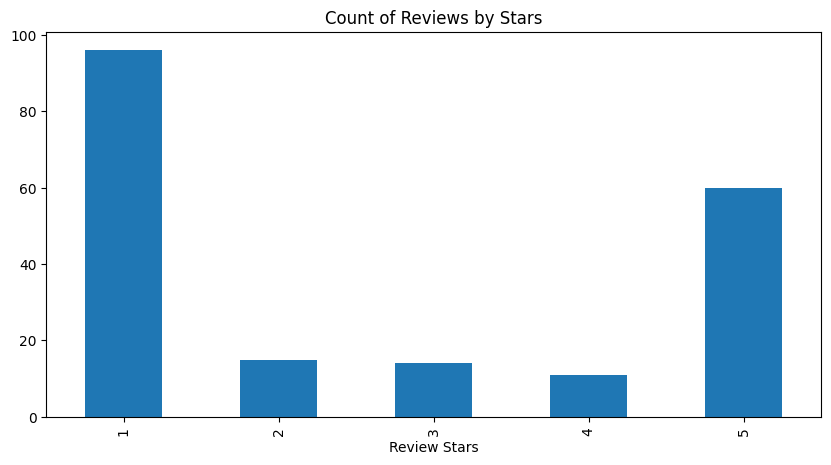

In [78]:
ax = df['grading'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Sentiment Analysis

**On ne choisit seulement le modèle de Roberta**

### Roberta

In [79]:
from transformers import pipeline

In [80]:
# Sentiment Analysis with Roberta

nlp = pipeline("sentiment-analysis", model=f"cardiffnlp/twitter-roberta-base-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en':
        dict = pd.DataFrame(nlp(text))
        dict['ID'] = index
        res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('LABEL_0', 'NEGATIVE')
res['label'] = res['label'].replace('LABEL_1', 'NEUTRAL')
res['label'] = res['label'].replace('LABEL_2', 'POSITIVE')
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (roberta)", "score": "score (roberta)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df


,Name,grading,date,Text,Language,label (roberta),score (roberta)
ID,,,,,,,
0,Reezaane Bundhoo,4,a year ago,"Delicious cakes, hot/cold beverages and great ...",en,POSITIVE,0.909130
1,Akram Althawbani,5,3 months ago,Best place but it's still camels man opinion. ...,en,POSITIVE,0.802349
2,Ibrahim Sobh,4,a month ago,"Amazing place to buy bread and sweets , always...",en,NEUTRAL,0.368061
3,Mareike Engel,5,5 months ago,Love the baguette and croissant. Staff is alwa...,en,POSITIVE,0.991683
4,shrishail kurangi,3,6 months ago,All the items I have tried here are really gre...,en,NEGATIVE,0.392930
...,...,...,...,...,...,...,...
191,RF 94 (RF94),5,2 years ago,Really heja the top,en,NEUTRAL,0.725054
192,Stéphane Bouland,2,10 months ago,Cold employees,en,NEUTRAL,0.608334
193,KANDE TOUNKARA,5,9 months ago,Top places,en,NEUTRAL,0.618987


### Kaludi/Reviews-Sentiment-Analysis

In [81]:
# Pas de neutral dans le modèle Kaludi
# Ce modèle n'est pas très connu et j'ai pas l'impression qu'il soit très performant

"""

nlp = pipeline("sentiment-analysis", model=f"Kaludi/Reviews-Sentiment-Analysis")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en':
        dict = pd.DataFrame(nlp(text))
        dict['ID'] = index
        res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (rev)", "score": "score (rev)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df


"""


'\n\nnlp = pipeline("sentiment-analysis", model=f"Kaludi/Reviews-Sentiment-Analysis")\n\n# Run the polarity score on the entire dataset\nres = pd.DataFrame(columns=[\'label\', \'score\'])\nfor index, row in df.iterrows():\n    text = row[\'Text\']\n    langue = row[\'Language\']\n    if langue == \'en\':\n        dict = pd.DataFrame(nlp(text))\n        dict[\'ID\'] = index\n        res = pd.concat([res, dict], axis=0)\n\n# Remplacement des valeurs\nres["ID"] = res[\'ID\'].astype(int)\nres = res.rename(columns={"label": "label (rev)", "score": "score (rev)"})\nres.set_index(\'ID\', inplace=True)\n\n# Merge the two dataframes\ndf = df.merge(res, left_index=True, right_index=True, how=\'left\')\ndf\n\n\n'

## nlptown/bert-base-multilingual-uncased-sentiment

In [82]:
# Sentiment Analysis Bert-base-uncased
# Plusieurs langages disponibles (dont le français)
#English	150k
#Dutch	80k
#German	137k
#French	140k
#Italian	72k
#Spanish
# Il classifie les phrases en étoiles (1 à 5)
# Ce modèle est connu

"""

nlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en' or langue == 'fr' or langue == 'es' or langue == 'it' or langue == 'de' or langue == 'nl':
        dict = pd.DataFrame(nlp(text))
        dict['ID'] = index
        res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('1 star', int(1))
res['label'] = res['label'].replace('2 stars', int(2))
res['label'] = res['label'].replace('3 stars', int(3))
res['label'] = res['label'].replace('4 stars', int(4))
res['label'] = res['label'].replace('5 stars', int(5))
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (Bert), over 5", "score": "score (Bert)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df

"""

'\n\nnlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")\n\n# Run the polarity score on the entire dataset\nres = pd.DataFrame(columns=[\'label\', \'score\'])\nfor index, row in df.iterrows():\n    text = row[\'Text\']\n    langue = row[\'Language\']\n    if langue == \'en\' or langue == \'fr\' or langue == \'es\' or langue == \'it\' or langue == \'de\' or langue == \'nl\':\n        dict = pd.DataFrame(nlp(text))\n        dict[\'ID\'] = index\n        res = pd.concat([res, dict], axis=0)\n\n# Remplacement des valeurs\nres[\'label\'] = res[\'label\'].replace(\'1 star\', int(1))\nres[\'label\'] = res[\'label\'].replace(\'2 stars\', int(2))\nres[\'label\'] = res[\'label\'].replace(\'3 stars\', int(3))\nres[\'label\'] = res[\'label\'].replace(\'4 stars\', int(4))\nres[\'label\'] = res[\'label\'].replace(\'5 stars\', int(5))\nres["ID"] = res[\'ID\'].astype(int)\nres = res.rename(columns={"label": "label (Bert), over 5", "score": "score (Bert)"})\n

## Exportation des données

In [83]:
import csv

chemin_fichier = 'processed_data.csv'

# Exporter le DataFrame dans un fichier CSV
df.to_csv(chemin_fichier, index=False)

